In [16]:
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2
import os
import pandas as pd

In [17]:
# Load the file using netCDF4
file_path = 'nc_data/sst.day.mean.2001.nc'
ds = xr.open_dataset(file_path)

file_path2 = 'nc_data/sst.day.mean.2000.nc'
ds2 = xr.open_dataset(file_path2)

(64, 64)


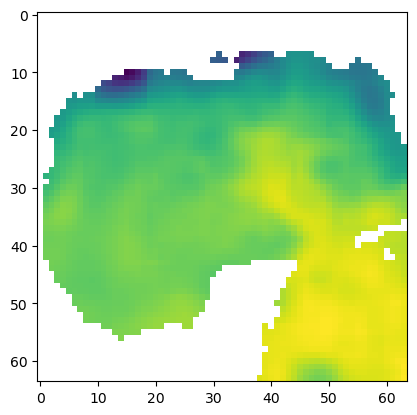

In [18]:
def select_region_sst(ds, lat_min=16.25, lat_max=32.25, lon_min=262, lon_max=278, time="2001-01-01"):
    # Select the region within these bounds
    sampled_region = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max), time=time)
    sst_data_array = sampled_region['sst'].values
    # Reverse the array along the first axis
    return sst_data_array[::-1]

X0 = select_region_sst(ds, time="2001-01-01")
X1 = select_region_sst(ds, time="2001-01-02")
X12 = select_region_sst(ds2, time="2000-01-02")
print(X0.shape)
import matplotlib.pyplot as plt
plt.imshow(X0, cmap='viridis')  # 'viridis' is a good colormap for scientific data
plt.show()

valid_mask = ~np.isnan(X0) & ~np.isnan(X1)
X0 = X0[valid_mask]
X1 = X1[valid_mask]

In [45]:
num_files = 6  # Adjust this number for the actual number of files
data_path_template = 'data/processed_sst_data{}.npy'
mask_path_template = 'data/sst_masks{}.npy'

data_paths = [data_path_template.format(i) for i in range(num_files)]
mask_paths = [mask_path_template.format(i) for i in range(num_files)]

min_val = 999
max_val = 0
for data_path, mask_path in zip(data_paths, mask_paths):
    sst_data = np.load(data_path)  # Shape: (time, lat, lon)
    min_val = min(min_val, np.min(sst_data[sst_data!=0]))
    max_val = max(max_val, np.max(sst_data))
    
print(min_val)
print(max_val)

4.5899997
33.5


(15762, 64, 64)


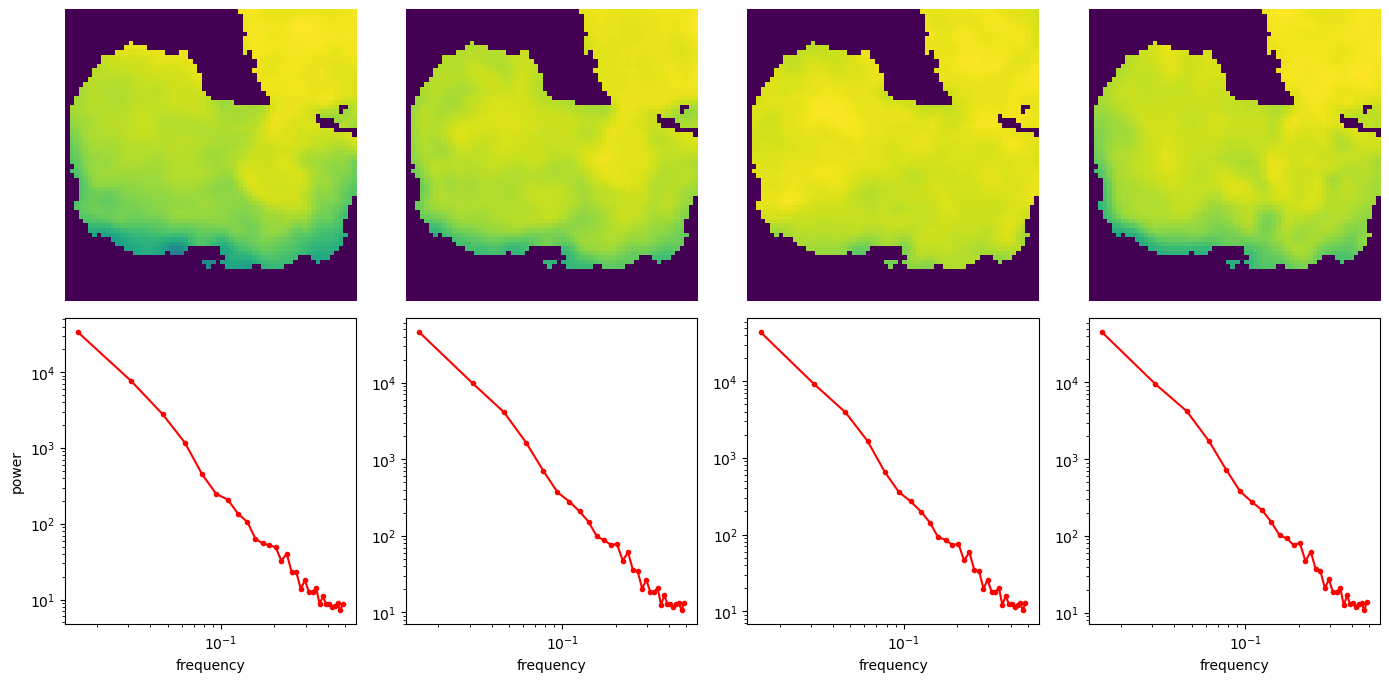

In [ ]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from pysteps.utils import spectral

start_date = datetime.strptime("2000-01-02", "%Y-%m-%d")
images = np.stack([np.load(p) for p in data_paths], axis=0)[0]
print(images.shape)
num_displayed_examples = 4  # Set to fit within a 2x4 grid
plt.figure(figsize=(14, 7))
for k in range(0, num_displayed_examples):
    plt.subplot(2, 4, k+1)
    plt.imshow((images[50*k] + 1) / 2)
    plt.axis('off')

for k in range(0, num_displayed_examples):
    images[k] = np.nan_to_num(images[50*k], nan=0.0)
    rapsd, frequencies = spectral.rapsd(np.array(images)[100*k], fft_method=np.fft, return_freq=True)
    plt.subplot(2, 4, 4 + k + 1)
    plt.plot(frequencies[1:], rapsd[1:], c='red', marker='o', markersize=3)  # Chop off the DC component.
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('frequency')
    if k == 0:
        plt.ylabel('power')

plt.tight_layout()
plt.show()

In [35]:
#main_images.shape
images.shape

(15762, 64, 64)

In [81]:
   
def calc_mean_log_rapsd_masked(x, mask, noise_baseline):
    spectra = []
    
    
    # Process actual data
    for img in x:
        masked_img = img * mask
        rapsd, frequencies = spectral.rapsd(masked_img, fft_method=np.fft, return_freq=True)
        
        # Normalize by noise baseline if requested
        rapsd = rapsd / (noise_baseline + 1e-30)
            
        spectra.append(rapsd)
    
    mean_log_rapsd = np.mean(np.log(np.array(spectra) + 1e-30), axis=0)
    return mean_log_rapsd, frequencies

In [110]:
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from pysteps.utils import spectral
from diffusers import DDPMScheduler

# Enable animation display in Jupyter Notebook
rc('animation', html='jshtml')

main_images = images#[0]
num_steps = 7
cycles_per_sec = 0.2
selected_image_idx = 1
noise_scale_min, noise_scale_max = 0.02, 50.0
noise_scales = np.logspace(np.log10(noise_scale_min), np.log10(noise_scale_max), num_steps)

scheduler = DDPMScheduler(num_train_timesteps=1000, prediction_type="x0")

DDPMScheduler(
    num_train_timesteps=1000,
    beta_start=0.0001,
    beta_end=0.02,
    #beta_schedule="squaredcos_cap_v2"
)

scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.30.3",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "x0",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

In [117]:
# Set up the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), width_ratios=[2, 1])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('frequency')
ax1.set_ylabel('power')
ax1.set_title('Frequency Distributions')
ax2.set_title('Noisy Image')
ax2.axis('off')

main_images = images
target_image = main_images[selected_image_idx]
target_image[target_image == 0] = -1
Mask = target_image != -1

target_image[Mask] = (target_image[Mask] - 4.5899997) / (33.5 - 4.5899997)
#4.5899997
#33.5

noise_spectra = []
for _ in range(100):
    noise = np.random.normal(0, 1, target_image.shape)
    masked_noise = noise * Mask
    noise_rapsd, _ = spectral.rapsd(masked_noise, fft_method=np.fft, return_freq=True)
    noise_spectra.append(noise_rapsd)
noise_baseline = np.mean(noise_spectra, axis=0)

# Prepare animation
artists = []
for i, t in enumerate(range(0, scheduler.config.num_train_timesteps, 10)):
    sqrt_alpha_prod = (scheduler.alphas_cumprod[t] ** 0.5).item()
    sqrt_one_minus_alpha_prod = ((1 - scheduler.alphas_cumprod[t]) ** 0.5).item()
    #print(sqrt_one_minus_alpha_prod)
    
    # Generate noise and noisy images
    current_noise = sqrt_one_minus_alpha_prod * np.random.randn(*images.shape[1:])
    current_noise[target_image == -1] = -1
    current_image = sqrt_alpha_prod * target_image
    current_image[target_image == -1] = -1
    
    noisy_images = current_image + current_noise
    #noisy_image = sqrt_alpha_prod * current_image + sqrt_one_minus_alpha_prod * noise
    
    # Calculate RAPSD
    mean_log_rapsd_noise, frequencies = calc_mean_log_rapsd_masked([current_noise], Mask, noise_baseline)
    mean_log_rapsd_noisy, _ = calc_mean_log_rapsd_masked([noisy_images], Mask, noise_baseline)
    mean_log_rapsd_base, _ = calc_mean_log_rapsd_masked([current_image], Mask, noise_baseline)

    # Plot the frequency distributions
    noise_line, = ax1.plot(frequencies[1:], np.exp(mean_log_rapsd_noise)[1:], 'blue', label='Noise' if i == 0 else "")
    base_line, = ax1.plot(frequencies[1:], np.exp(mean_log_rapsd_base)[1:], 'red', label='Image' if i == 0 else "")
    noisy_line, = ax1.plot(frequencies[1:], np.exp(mean_log_rapsd_noisy)[1:], 'green', label='Noisy Image' if i == 0 else "")

    # Show the noisy image
    img_artist = ax2.imshow(np.clip((noisy_images + 1) / 2, 0, 1), cmap='gray', animated=True)

    # Collect artists for animation
    artists.append([noise_line, noisy_line, base_line, img_artist])
print("Done")
plt.close()

Done


In [118]:
# Add a legend to the first frame
if artists:
    ax1.legend()

# Create the animation
anim = animation.ArtistAnimation(fig, artists, interval=1000 / (num_steps * cycles_per_sec), blit=True)

anim

Let X be the observation we want to predict and Y be some prediction of X.

At step t we draw some sample $t \sim N(\alpha_t X, (1-\alpha_t)I)$




We have two vectors $X_0$ and $X_1$. We want to test if they are sufficently diffrent at noising step t.

At step t both have distributions:
$N(\alpha * X, (1 - \alpha)I)$

This means there diffrence is also normal with shape:

$N(\alpha(X_0 - X_1), 2(1-\alpha)I)$

This means we can do a simplified Mahalanobis distance to compute the probability a sample was drawn from $N(0, 2(1-\alpha)I)$ instead

$\frac{\alpha||(X_0 - X_1)||_2}{\sqrt{(2(1-\alpha))}}$

This is known to follow a chi-squared distribution with threshold:

# On conservation of energy

- With some simplifications we can measure the conservation of energy as just the difference of the sum of the values between this frame and the previous
 The distribution of each is then:
    $S_i \sim N(\alpha \sum X_i, n(1-\alpha))$

So the diffrence of the two would be:

$D \sim N(\alpha(\sum X_0 - \sum X_1), 2n(1-\alpha))$

This is a single dim normal distribution so we can compute the 95% confidence intervel that it includes zero with a z score

1. The mean and variance of \(D\) are:
$\mu_D = \alpha (\sum X_0 - \sum X_1)$
$\sigma_D^2 = 2n(1-\alpha)$

2. Standardizing \(D\), the standard normal variable \(Z\) is:
$Z = \frac{D - \mu_D}{\sigma_D}$

The 95\% confidence interval for \(Z\) is given by:
$P(-1.96 \leq Z \leq 1.96) = 0.95.$

3. Transforming back to the scale of \(D\), the 95\% confidence interval is:
$\mu_D \pm 1.96 \cdot \sigma_D.$

Substituting \(\mu_D\) and \(\sigma_D\):
$\alpha (\sum X_0 - \sum X_1) \pm 1.96 \cdot \sqrt{2n(1-\alpha)}.$

To check if zero lies within the interval, the null hypothesis \(H_0\) (energy is conserved) is not rejected if:
$-\alpha (\sum X_0 - \sum X_1) \leq 1.96 \cdot \sqrt{2n(1-\alpha)}.$

In [ ]:
Threshold_distance = np.sqrt(chi2.ppf(0.95, df = np.size(X0)))
Threshold_distance

np.linalg.norm(X0 - X1)

10.177961

In [ ]:
sst_data = np.load('data/processed_sst_data0.npy')  # Shape: (time, lat, lon)
masks = np.load('data/sst_masks0.npy')  # Shape: (time, lat, lon)
print(sst_data.shape, flush = True)

(15762, 64, 64)


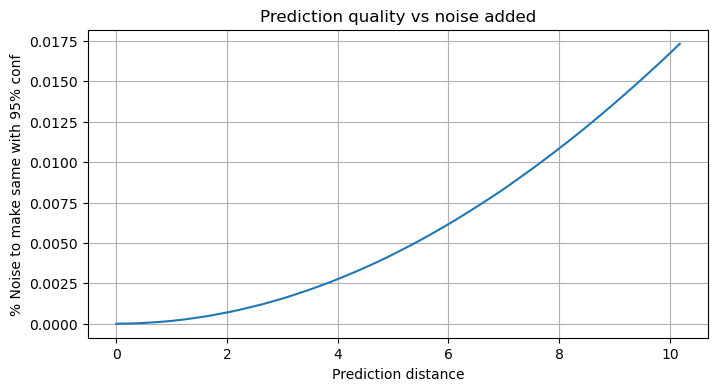

In [ ]:
def find_alpha_threshold(signal_diff):

    # Find the largest alpha where the signal difference is indistinguishable from noise
    alpha_values = np.linspace(0, 1, 100001)
    for alpha in reversed(alpha_values):
        #if np.sqrt(alpha) * signal_diff <= 1.96 * np.sqrt(2 * (1 - alpha)):
        if alpha * signal_diff <= Threshold_distance * np.sqrt(2 * (1 - alpha)):
            return alpha
    return 0.0  # If no alpha satisfies the condition, return 0

def plot_pred_samples(old_pic, new_pic):

    alpha_values = np.linspace(0, 1, 51)
    needed_alpha = []
    pred_mse = []
    for alpha in alpha_values:
        pred = (alpha*old_pic + (1-alpha)*new_pic)
        signal_diff = np.linalg.norm(old_pic - pred)
        pred_mse.append(signal_diff)
        needed_alpha.append(1 - find_alpha_threshold(signal_diff))
    plt.figure(figsize=(8, 4))
    plt.plot(pred_mse, needed_alpha, label="Scaled Signal Difference")
    plt.xlabel("Prediction distance")
    plt.ylabel("% Noise to make same with 95% conf")
    plt.title("Prediction quality vs noise added")
    plt.grid()
    plt.show()
plot_pred_samples(X0, X1)

In [ ]:
import numpy as np
from Data_Loader import prepare_datasets  # type: ignore

# Constants
Threshold_distance = 1.96  # 95% confidence level

import torch

def compute_energy(input):
    return input.sum(dim=(1, 2, 3))


def find_alpha_threshold(signal_diff):
    alpha_values = np.linspace(0, 1, 100001)
    mask = alpha_values * signal_diff <= Threshold_distance * np.sqrt(2 * (1 - alpha_values))
    indices = np.where(mask)[0]
    return alpha_values[indices[-1]] if indices.size > 0 else 0.0


def find_alpha_threshold_energy(sum_diff, n):
    alpha_values = torch.linspace(0, 1, 100001, device=sum_diff.device)
    mask = alpha_values * sum_diff <= Threshold_distance * torch.sqrt(2 * n * (1 - alpha_values))
    indices = torch.where(mask)[0]
    return alpha_values[indices[-1]].item() if indices.numel() > 0 else 0.0


# Data Loading
num_files = 3
data_path_template = "data/processed_sst_data{}.npy"
mask_path_template = "data/sst_masks{}.npy"
good_pred_template = "data/good_pred{}.npy"

data_paths = [data_path_template.format(i) for i in range(num_files)]
mask_paths = [mask_path_template.format(i) for i in range(num_files)]
good_pred_paths = [good_pred_template.format(i) for i in range(num_files)]

train_dataloader, test_dataloader = prepare_datasets(
    data_paths, mask_paths, good_pred_paths, train_ratio=0.75, sequence_length=1, batch_size=8
)
del test_dataloader

# Initialize Accumulators
total_alpha_context_target = 0.0
total_alpha_week_target = 0.0
total_alpha_energy = 0.0
num_batches = 0

# Training Loop
for context_frames, mask, week_pred, _, _ in train_dataloader:
    # Batch-wise processing
    target_frame = context_frames[:, -1:, :, :]
    context_frame = context_frames[:, :1, :, :]
    n = context_frame.shape[2] * context_frame.shape[3]

    # Compute energy
    energy_predicted = compute_energy(context_frame)
    energy_target = compute_energy(target_frame)


    # Compute signal differences
    #signal_diff_context = torch.norm(context_frame - target_frame, dim=(2, 3))[:, 0]
    #signal_diff_week = torch.norm(week_pred - target_frame, dim=(2, 3))[:, 0]
    signal_diff_energy = np.abs(energy_predicted - energy_target)

    # Compute alpha thresholds
    alpha_energy = find_alpha_threshold_energy(signal_diff_energy.mean(), n)
    #alpha_context_target = find_alpha_threshold(signal_diff_context.mean().item())
    #alpha_week_target = find_alpha_threshold(signal_diff_week.mean().item())
    

    # Update accumulators
    #total_alpha_context_target += alpha_context_target
    #total_alpha_week_target += alpha_week_target
    total_alpha_energy += alpha_energy
    num_batches += 1

# Compute averages
average_alpha_context_target = total_alpha_context_target / num_batches
average_alpha_week_target = total_alpha_week_target / num_batches
average_alpha_energy = total_alpha_energy / num_batches

# Print results
print(f"Average alpha_threshold (context vs. target): {average_alpha_context_target}")
print(f"Average alpha_threshold (week_pred vs. target): {average_alpha_week_target}")
print(f"Average alpha_threshold (energy_target vs. energy_prior): {average_alpha_energy}")


Average alpha_threshold (context vs. target): 0.0
Average alpha_threshold (week_pred vs. target): 0.0
Average alpha_threshold (energy_target vs. energy_prior): 0.7558445434832644


In [ ]:
from diffusers import DDPMScheduler
import numpy as np
#Average alpha_threshold (context vs. target): 0.6239302060221873
#Average alpha_threshold (week_pred vs. target): 0.9603246185193584
#Average alpha_threshold (energy_target vs. energy_prior): 75584454348326
#212
#58
#162
# Initialize the scheduler
scheduler = DDPMScheduler(num_train_timesteps=1000, prediction_type="x0")

# Compute cumulative alpha values (\( \bar{\alpha}_t \))
alphas_cumprod = scheduler.alphas_cumprod.numpy()

def find_timestep_from_alpha(average_alpha):
    """
    Finds the closest timestep corresponding to the given alpha value.
    """
    # Find the index of the alpha value closest to the average_alpha
    closest_timestep = np.argmin(np.abs(alphas_cumprod - average_alpha))
    return closest_timestep

print(find_timestep_from_alpha(average_alpha_context_target))
print(find_timestep_from_alpha(average_alpha_week_target))
print(find_timestep_from_alpha(average_alpha_energy))

c:\Users\marli\miniconda3\envs\gen_ai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


999
999
162


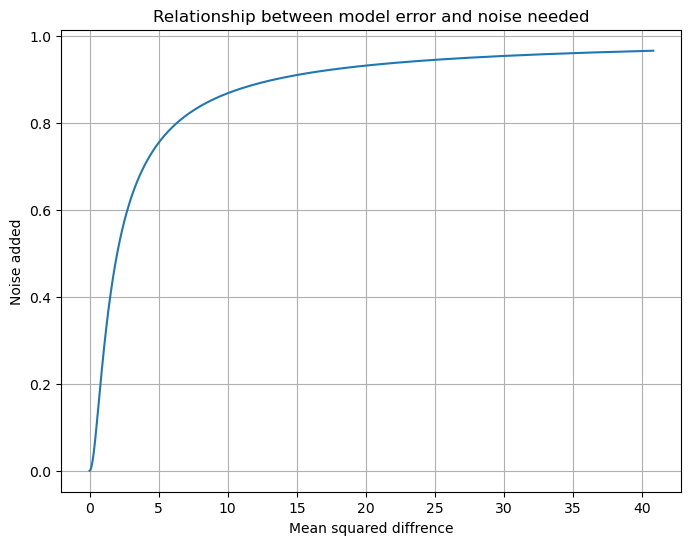

In [ ]:
y_values = np.linspace(0, 1, 500)
#Threshold_distance
x_values = np.sqrt(2 * (1 -y_values)) / y_values

Filter_Mask = x_values < 80/Threshold_distance
y_values = y_values[Filter_Mask]
x_values = x_values[Filter_Mask]

plt.figure(figsize=(8, 6))
plt.plot(x_values, 1 - y_values)
plt.ylabel("Noise added")
plt.xlabel("Mean squared diffrence")
plt.title("Relationship between model error and noise needed")
plt.grid(True)
plt.show()

In [ ]:
def plot_needed_alpha_analysis(needed_alpha, start_date="2001-01-01", end_date="2001-12-31"):
    """
    Plots the distribution of `needed_alpha` values as a histogram with an average line
    and the average grouped by month as subplots.

    Parameters:
    - needed_alpha (list or np.array): Array of `needed_alpha` values for consecutive days.
    - start_date (str): Start date of the analysis period in "YYYY-MM-DD" format.
    - end_date (str): End date of the analysis period in "YYYY-MM-DD" format.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd

    # Generate date range
    dates = pd.date_range(start_date, end_date).strftime('%Y-%m-%d')

    # Ensure `needed_alpha` length matches the date range - 1 (pairs of days)
    if len(needed_alpha) != len(dates) - 1:
        raise ValueError("The length of `needed_alpha` must be one less than the number of dates in the range.")

    # Create a DataFrame for grouping
    df = pd.DataFrame({
        "date": dates[:-1],  # Exclude the last day
        "needed_alpha": needed_alpha
    })
    df["month"] = pd.to_datetime(df["date"]).dt.month

    # Calculate monthly averages
    monthly_avg = df.groupby("month")["needed_alpha"].mean()

    # Calculate overall average for the histogram
    overall_avg = np.mean(needed_alpha)

    # Create subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 12), constrained_layout=True)

    # Plot histogram of needed_alpha
    axes[0].hist(needed_alpha, bins=20, alpha=0.7, color='blue', edgecolor='black')
    axes[0].axvline(overall_avg, color='red', linestyle='--', linewidth=2, label=f"Average = {overall_avg:.2f}")
    axes[0].set_title("Distribution of needed_alpha", fontsize=14)
    axes[0].set_xlabel("needed_alpha", fontsize=12)
    axes[0].set_ylabel("Frequency", fontsize=12)
    axes[0].legend(fontsize=10)
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot monthly averages
    axes[1].bar(monthly_avg.index, monthly_avg.values, alpha=0.7, color='orange', edgecolor='black')
    axes[1].set_title("Average needed_alpha by Month", fontsize=14)
    axes[1].set_xlabel("Month", fontsize=12)
    axes[1].set_ylabel("Average needed_alpha", fontsize=12)
    axes[1].set_xticks(range(1, 13))
    axes[1].set_xticklabels([
        "Jan", "Feb", "Mar", "Apr", "May", "Jun",
        "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
    ], rotation=45)
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plots
    plt.show()

In [ ]:
needed_alpha = []
dates = pd.date_range("2001-01-01", "2001-12-31").strftime('%Y-%m-%d')
for i in range(len(dates) - 1):
    date1 = dates[i]
    date2 = dates[i + 1]

    # Extract SST for the selected days
    X0 = select_region_sst(ds, time=date1)
    X1 = select_region_sst(ds, time=date2)

    # Ensure valid_mask is defined to exclude NaNs
    valid_mask = ~np.isnan(X0) & ~np.isnan(X1)

    # Apply the mask
    X0 = X0[valid_mask]
    X1 = X1[valid_mask]

    # Compute signal difference
    signal_diff = np.linalg.norm(X0 - X1)

    # Calculate the alpha adjustment
    alpha_threshold = find_alpha_threshold(signal_diff)
    needed_alpha.append(1 - alpha_threshold)
    
plot_needed_alpha_analysis(needed_alpha)

KeyboardInterrupt: 

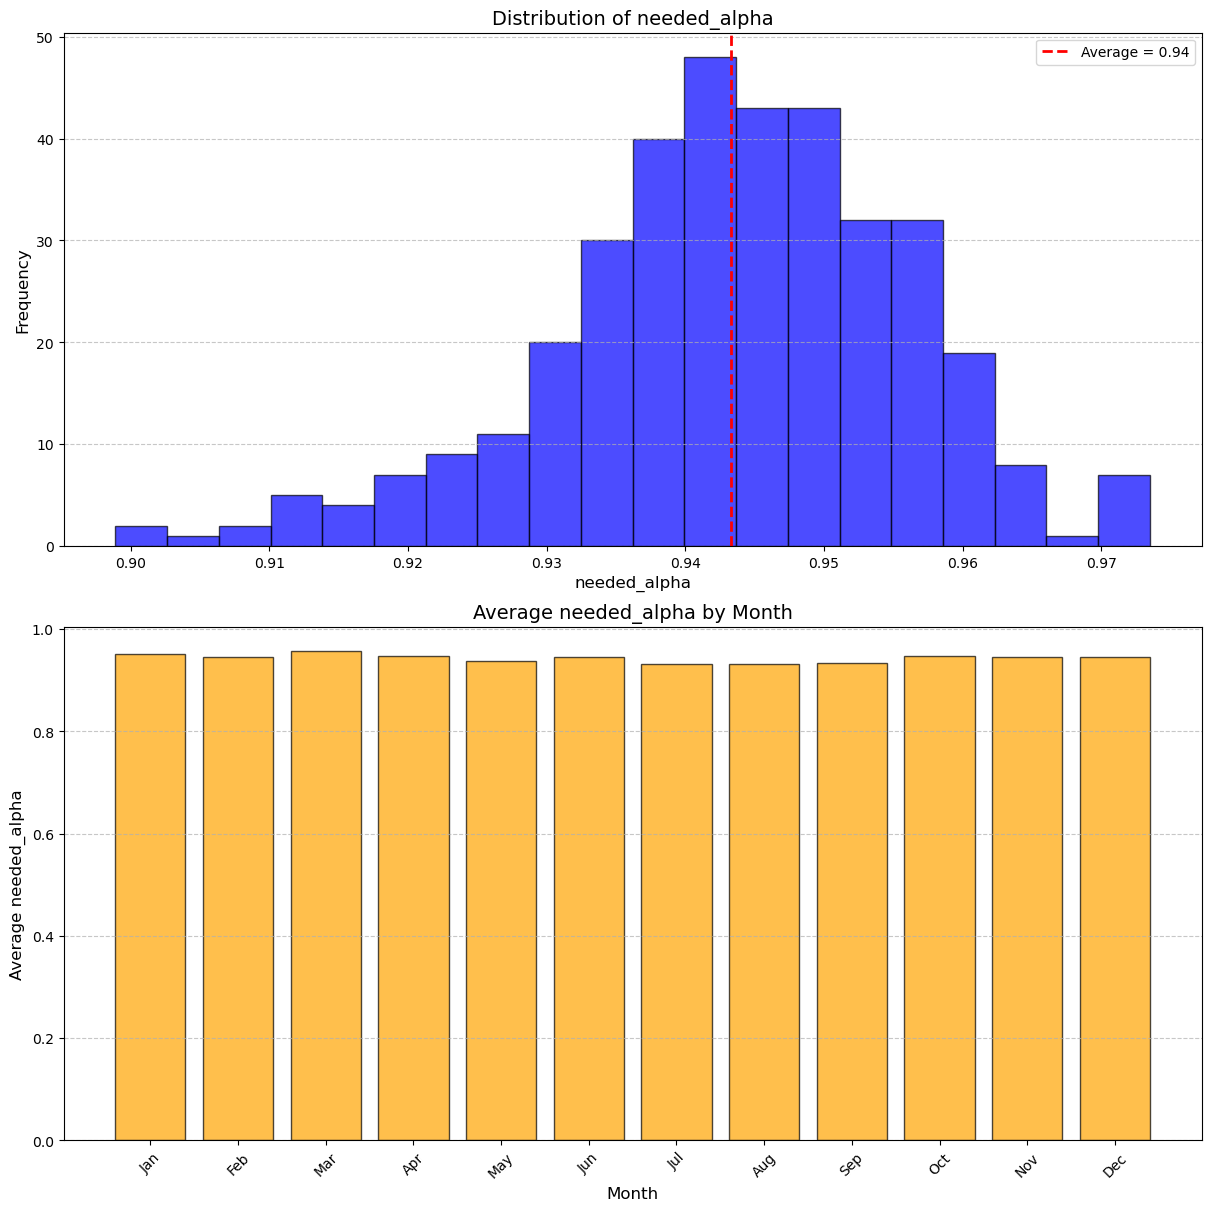

In [ ]:
needed_alpha = []
dates = pd.date_range("2001-01-01", "2001-12-31").strftime('%Y-%m-%d')
dates2 = pd.date_range("2000-01-01", "2000-12-31").strftime('%Y-%m-%d')
for i in range(len(dates)-1):
    date1 = dates[i]
    date2 = dates2[i]

    # Extract SST for the selected days
    X0 = select_region_sst(ds, time=date1)
    X1 = select_region_sst(ds2, time=date2)

    # Ensure valid_mask is defined to exclude NaNs
    valid_mask = ~np.isnan(X0) & ~np.isnan(X1)

    # Apply the mask
    X0 = X0[valid_mask]
    X1 = X1[valid_mask]

    # Compute signal difference
    signal_diff = np.linalg.norm(X0 - X1)

    # Calculate the alpha adjustment
    alpha_threshold = find_alpha_threshold(signal_diff)
    needed_alpha.append(1 - alpha_threshold)
plot_needed_alpha_analysis(needed_alpha)